In [2]:
!pip install -q control
!pip install -q tellurium

import control
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

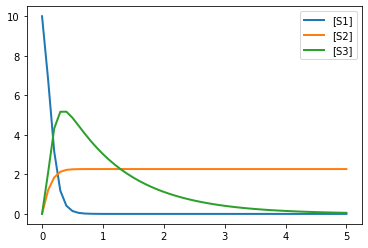

In [3]:
NONLINEAR_MDL = """
JN1: S1 -> S2; k1*S1
JN2: S1 +  S2 -> 3 S3; k2*S1*S2
JN3: S3 -> ; k3*S3
JN4: 2 S1 + S3 -> S2; k4*S1*S3

k1 = 2
k2 = 1.5
k3 = 1
k4 = 0.5
S1 = 10
S2 = 0
S3 = 0
"""
NONLINEAR_RR = te.loada(NONLINEAR_MDL)
NONLINEAR_DATA = NONLINEAR_RR.simulate()
NONLINEAR_RR.plot(NONLINEAR_DATA)

# Helper Functions

In [4]:
def getStateDct(time, roadrunner=NONLINEAR_RR):
    """
    Retrieves the value of state at the specified time.
    Changes the time of the roadrunner.
    
    Parameters
    ----------
    time: float
    roadrunner: ExtendedRoadrunner
    
    Returns
    -------
    dict
        key: species name
        value: species value
    """
    roadrunner.reset()
    if time > 0:
        roadrunner.simulate(0, time)
    species_lst = roadrunner.getFloatingSpeciesIds()
    dct = {s: roadrunner[s] for s in species_lst}
    return dct
    
        
# Tests
dct = getStateDct(0.5)
assert(len(dct) == 3)
dct1 = getStateDct(1)  # Get different values at a different time
assert(all([dct[s] != dct1[s] for s in dct.keys()]))
print("OK!")

OK!


In [5]:
def getStateValues(time, **kwargs):
    """
    Gets the values of state at the specified time.
    
    Parameters
    ----------
    time: float
    kwargs: dict
        keyword arguments for getStateDct
        
    Returns
    -------
    np.array
    """
    return np.array(list(getStateDct(time, **kwargs).values()))
        
# Tests
arr = getStateValues(0)
assert(isinstance(arr, np.ndarray))
assert(len(arr) == 3)
print("OK!")

OK!


In [6]:
def plotRR(roadrunner=NONLINEAR_RR, is_plot=True):
    """
    Plots species from running a simulation.
    """
    roadrunner.reset()
    roadrunner.simulate(0, 5, 100)
    if is_plot:
        roadrunner.plot()

# Tests
plotRR(is_plot=False)
print("OK!")

OK!


# Accuracy Analysis Function

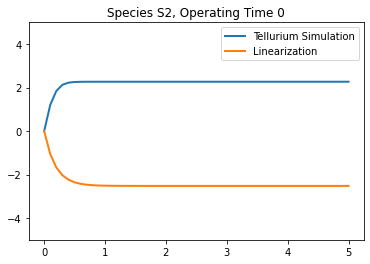

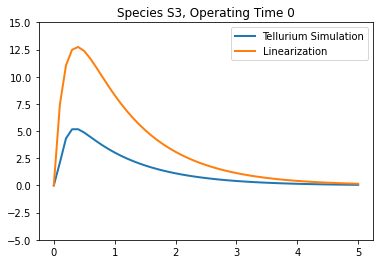

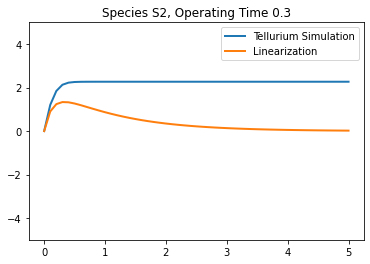

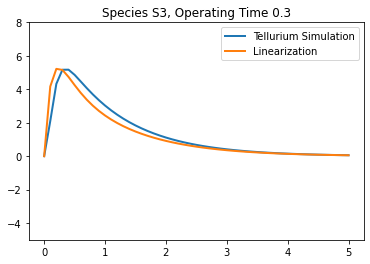

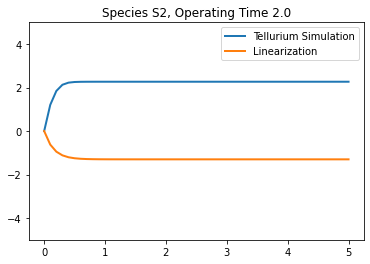

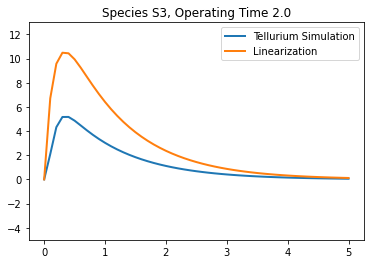

In [7]:
def analyze(time, speciesname):

    """
    Plots comparisons of the Tellurium simulation of the original model with
    its linearization at a time point for a particular species.
    The analysis is for NONLINEAR_MDL. 

    Parameters
    ----------
    time: float
    speciesname: str
        e.g. "S2", "S3"

    Returns
    -------
    result.y: numpy.ndarray
      Output values from linearization

    """

  # Tellurium simulation
    NONLINEAR_MDL = """
    JN1: S1 -> S2; k1*S1
    JN2: S1 +  S2 -> 3 S3; k2*S1*S2
    JN3: S3 -> ; k3*S3
    JN4: 2 S1 + S3 -> S2; k4*S1*S3

    k1 = 2
    k2 = 1.5
    k3 = 1
    k4 = 0.5
    S1 = 10
    S2 = 0
    S3 = 0
    """
    NONLINEAR_RR = te.loada(NONLINEAR_MDL)
    NONLINEAR_DATA = NONLINEAR_RR.simulate()

    # Chosen operating point
    OP_TIME = time
    OP_VEC = getStateValues(OP_TIME)
    NUM_STATE = len(OP_VEC)
    X0 = getStateValues(0)  # Initial values for simulation from time 0

    # Calculate Jacobian matrix A at operating point
    NONLINEAR_RR.reset()
    if OP_TIME > 0:
      NONLINEAR_RR.simulate(0, OP_TIME)
    else:
      NONLINEAR_RR.simulate(0)

    # Extract the Jacobian
    A = NONLINEAR_RR.getFullJacobian()
    

    # Construct B input matrix
    B = np.array([1, 0, 0])
    B = np.reshape(B, (NUM_STATE, 1))
    np.shape(B)

    # Construct C output matrix
    C = np.array([0, 0, 1])
    C = np.reshape(C, (1, NUM_STATE))
    C_SHAPE = np.shape(C)

    # Construct D matrix. Same # rows as inputs, same # columns as outputs
    D = 0

    #Construct control object
    NONLINEAR_SS = control.StateSpace(A, B, C, D)

    # Simulate ouput of linear system
    times = [0.1*v for v in range(51)]  #time array
    result = control.forced_response(NONLINEAR_SS, times, X0=getStateValues(0)) 
    
    # Create species index for plotting
    dct = {"S1": 0, "S2": 1, "S3": 2}
    GRAPH_SPECIES = dct[speciesname]

    # Plot the results
    plt.plot (NONLINEAR_DATA[:,0], NONLINEAR_DATA[:,GRAPH_SPECIES+1], label = "Tellurium Simulation", linewidth=2)
    plt.plot(result.t.flatten(), result.x[GRAPH_SPECIES].flatten(), label = "Linearization", linewidth=2)
    
    # fit lines in plotting window
    YMAX_LIN = np.amax(result.x[GRAPH_SPECIES]) # max data value of linearization
    YMAX_TE = np.amax(NONLINEAR_DATA[:,GRAPH_SPECIES+1]) # max value of te simulation
    if YMAX_LIN > YMAX_TE:  # compare max values between data sets
      plt.ylim([-5, np.ceil(YMAX_LIN+2)])
    else:
      plt.ylim([-5, np.ceil(YMAX_TE+2)])
    
    #Title and legend
    plt.title("Species " + speciesname + ", Operating Time " + str(time))
    plt.legend()
    #Return output values for function test
    return result.y

# Test
for time in [0, 0.3, 2.0]:
    for speciesname in ["S2", "S3"]:
        arr = analyze(time, speciesname)
        assert(isinstance(arr, np.ndarray))
        plt.show()





Question 3


***Where are the largest discrepancies between the original simulation and the linearized models? Why?***

The largest discrepancies between the original simultaoin and the linearized models occur at the operating times of 0 and 2. 

S2 has the largest discrepancies since the linearized model outputs almost completely opposite values to the original simulation.
Similarly, for species S3, the 0 and 2 operating times also show the largest discrepancies. The linearized models display much higher values compared to the original simulation for S3. 

For the operating time of 0.3, the linearized model for species S3 is a very close match whereas species S2 is only kind of close to the original. 


This behavior can be explained by the mathematical nature of linearization. In order to linearize system equations, we use a first order Taylor approximation to evaluate the system at a certain operating point. The values of the state variables change depending on the operating point used. Most imporantly, the first order Taylor approximation includes the calculation of both the summation of each of the partial derivatives with respect to each of the state variables, as well as the distance between the operating values and normal values.


It makes sense that the operating times of 0 and 2 produce inaccurate linear approximations because the species concentrations are either dynamically changing (high slope values - partial derivatives account for this in the first order Taylor series approximations) and/or have great distances between the operating values and normal values. 

Operating time 0.3 produces the closest approximation because each species has a relatively small slope at that operating point, and there is less distance between the operating value and normal values since both species S1 and S2 maintain relatively constant values after ~0.3 seconds. Interestingly, species S2 at the 0.3 operating point starts to take on a curve shape similar to species S3 after the ~0.5 second time point. This is after the point where S1 becomes 0. This makes sense because the NONLINEAR_MDL states that S2 is affected by both S1 and S3. While we're approximating around the state values at time 0.3, species S1 only contributes until its slope and normal values become 0. Then S3 is left to contribute to the linear approximation of S2. But since S3 has negative slope after the operating point, it starts contributing negative values to the calculation of S2, causing the values from the linear approximation to continue decreasing further from the original simulation values. 